## Urban seismic monitoring in Brasilia, Brazil
This notebook is useful to reproduce the Change Point Analysis presented in the paper "Urban seismic monitoring in Brasilia, Brazil"

Google Mobility Reports downloaded from www.google.com/covid19/mobility/

Required:

python rupture (and its dependencies) pandas jupyter notebook this should be easy to set up in a conda env: conda create -c conda-forge -n covid python=3.7 rupture pandas jupyter notebook

Authors: Susanne Maciel @sutaina, Marcelo Peres Rocha and Martin Schimmel

In [2]:
#!pip3 install ruptures

    100% |████████████████████████████████| 20.2MB 62kB/s eta 0:00:01    83% |██████████████████████████▉     | 16.9MB 557kB/s eta 0:00:06
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Running setup.py bdist_wheel for ruptures ... done
  Stored in directory: /home/susanne/.cache/pip/wheels/8b/a2/15/6e7b600d1415d6d3e746e3004dc23eef3bf7778d35e6afebac
Successfully built ruptures


In [1]:
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import numpy as np

import seaborn as sns
import scipy.stats as stats



import datetime
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from obspy import UTCDateTime
import os
import datetime
import textwrap

wrapper = textwrap.TextWrapper(width=15,break_long_words=False)
scale = 1e9
scaleIsolamento = 1
bans = {"2020-02-22 06:00":'Carnival Saturday',
        "2020-03-12 06:00":'State Decree 01',
        "2020-03-20 06:00":'State Decree 02',
        "2020-04-10 06:00":'Good Friday'}

Reading seismic displacement files already converted to csv format

In [2]:
seismo2020 = pd.read_csv('data/2020-01-displacement_RMS-Jan-Apr.csv', parse_dates=[0],index_col=0,  delimiter=';')
seismo2019 = pd.read_csv('data/2019-01-displacement_RMS-Jan-Apr.csv', parse_dates=[0],index_col=0,  delimiter=';')
seismo2018 = pd.read_csv('data/2018-01-displacement_RMS-Jan-Apr.csv', parse_dates=[0],index_col=0,  delimiter=';')
seismo2016 = pd.read_csv('data/2016-01-displacement_RMS-Jan-Apr.csv', parse_dates=[0],index_col=0,  delimiter=';')
seismo2015 = pd.read_csv('data/2015-02-displacement_RMS-Feb-Apr.csv', parse_dates=[0],index_col=0,  delimiter=';')

Reading and ploting mobility reports

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([ 737470.,  737485.,  737499.,  737516.,  737530.,  737546.,  737560.]),
 <a list of 7 Text major ticklabel objects>)

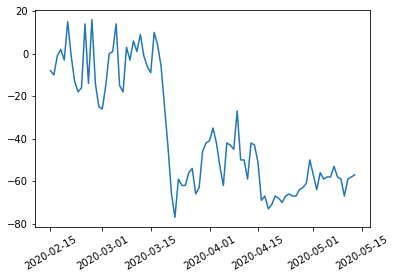

In [4]:

Isolamento = pd.read_csv('data/Global_Mobility_Report.csv',parse_dates=[4],index_col=4,  delimiter=',')

base='grocery_and_pharmacy_percent_change_from_baseline'
baseS="Grocery and pharmacy"
base2='parks_percent_change_from_baseline'
base2S="Parks"
base3='transit_stations_percent_change_from_baseline'
base3S="Transit"
base4='workplaces_percent_change_from_baseline'
base4S="Workplaces"
base5='residential_percent_change_from_baseline'
base5S="Residential (inverted)"
mask=(Isolamento['sub_region_1']=='Federal District')
isola = Isolamento[base2].copy().loc[mask]
isola2 = np.array(isola)
plt.plot(isola.index,isola2)
plt.xticks(rotation=30)

In [5]:
data = seismo2020
band='4.0-14.0'
time_ini="9:00"
time_end="21:00"
rs = data[band].copy().between_time(time_ini,time_end)
rs = rs.resample("12H" ).median().tshift(12, "H")
#rs = rs.resample("1D" ).median().tshift(0, "H")

In [6]:
day0 = max(rs.index[0],isola.index[0])
dayL = min(rs.index[-1],isola.index[-1])
print(day0)
print(dayL)
mask1 = (rs.index>=day0) & (rs.index<=dayL)
rsCut = rs.loc[mask1]
mask2 = (isola.index>=day0) & (isola.index<=dayL)
isolaCut = isola.loc[mask2]
rs2 = np.array(rsCut)
isola2 = np.array(isolaCut)

2020-02-15 00:00:00
2020-05-01 00:00:00


In [7]:
bans = {"2020-03-12 06:00":'State Decree 01',
        "2020-03-20 06:00":'State Decree 02'}

# detection
algo = rpt.Pelt(model="rbf").fit(rs2)
result = algo.predict(pen=2)

# detection
algo2 = rpt.Pelt(model="rbf").fit(isola2)
resultisola = algo2.predict(pen=2)

print(result)
print(resultisola)


[70, 90, 145, 153]
[35, 45, 60, 77]


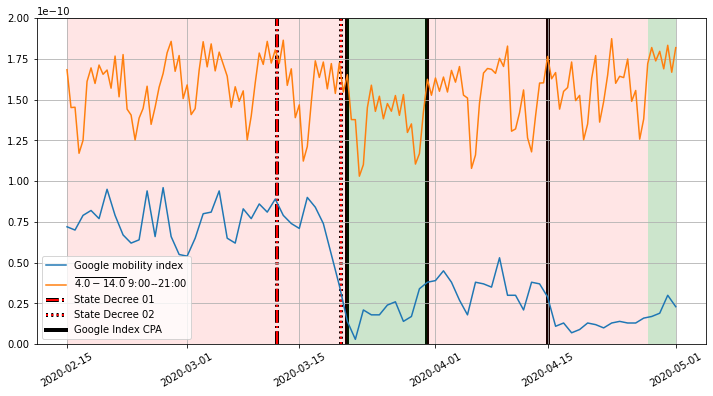

In [8]:

plt.figure(figsize=[12,6])
    
plt.plot(isolaCut.index,isolaCut/1e12+.8e-10, label="Google mobility index")       
#plt.plot(data[band].index,data[band], label="$%s$"%band)
plt.plot(rsCut.index, rsCut+.5e-10, label="$\overline{%s}$ %s--%s"%(band,time_ini,time_end))#, c='purple')
plt.ylim([0,2e-10])
plt.legend()
plt.xticks(rotation=30)
plt.grid()


#plt.gca().set_axisbelow(True)


for iban,ban in enumerate(bans.keys()):
    
    
    plt.axvline(UTCDateTime(ban).datetime,
    color='r',
    linewidth=2,
    linestyle=['-.', ':'][iban],
    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
    zorder=-9,
    label='\n'.join(wrapper.wrap(bans[ban])))
    plt.legend(loc='lower left')
plt.axvspan(rsCut.index[0],rsCut.index[result[0]],facecolor='red', edgecolor="none",alpha=0.1)
for irup,rup in enumerate(result[0:-2]):
    if (irup % 2) == 0:
        plt.axvspan(rsCut.index[result[irup]],rsCut.index[result[irup+1]],facecolor='green', edgecolor="none",alpha=0.2)
    else:
        plt.axvspan(rsCut.index[result[irup]],rsCut.index[result[irup+1]],facecolor='red', edgecolor="none",alpha=0.1)
    
    plt.legend(loc='lower left')
if (irup % 2) == 0:
    plt.axvspan(rsCut.index[result[irup]],rsCut.index[-1],facecolor='red', edgecolor="none",alpha=0.1)
else:
    plt.axvspan(rsCut.index[result[irup+1]],rsCut.index[-1],facecolor='green', edgecolor="none",alpha=0.2)
        

for irup,rup in enumerate(resultisola[0:-1]):
    plt.axvline(isola.index[rup],
    color='k',
    linewidth=2,
    linestyle='-',
    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
    zorder=-9)
    plt.legend(loc='lower left') 
    
plt.axvline(isola.index[rup],
    color='k',
    linewidth=2,
    linestyle='-',
    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
    zorder=-9,
    label='Google Index CPA')
plt.legend(loc='lower left')

0 2020-03-12 06:00
1 2020-03-20 06:00
isola 2020-03-21 00:00:00 35
isola 2020-03-31 00:00:00 45
isola 2020-04-15 00:00:00 60
isola 2020-05-02 00:00:00 77
rs2 2020-02-05 12:00:00 70
rs2 2020-02-15 12:00:00 90
rs2 2020-03-14 00:00:00 145
rs2 2020-03-18 00:00:00 153
0 35
35 45
45 60
60 77


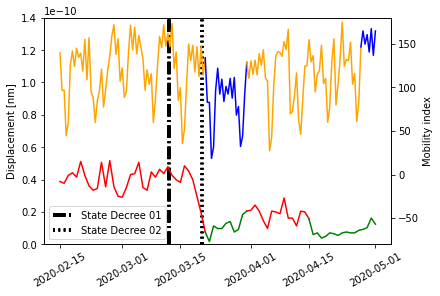

In [9]:
from matplotlib.ticker import AutoMinorLocator
#plt.figure(figsize=[8,3])
fig, ax = plt.subplots(constrained_layout=True)    
#plt.plot(isolaCut.index,isolaCut/1e12+.8e-10, label="Google mobility index")       
#plt.plot(data[band].index,data[band], label="$%s$"%band)
#plt.plot(rsCut.index, rsCut+.5e-10, label="$\overline{%s}$ %s--%s"%(band,time_ini,time_end))#, c='purple')
#plt.ylim([0,2e-10])
#plt.legend()
#plt.xticks(rotation=30)
#plt.grid()
for iban,ban in enumerate(bans.keys()):
    
    
    ax.axvline(UTCDateTime(ban).datetime,
    color='k',
    linewidth=2,
    linestyle=['-.', ':'][iban],
    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
    zorder=-9,
    label='\n'.join(wrapper.wrap(bans[ban])))
    #plt.legend(loc='lower right',bbox_to_anchor=(1.33, 0))
    plt.legend(loc='lower left')
#

for iban,ban in enumerate(bans.keys()):
    print(iban,ban)
for irup,rup in enumerate(resultisola):
    print("isola", isola.index[rup],rup)
for irup,rup in enumerate(result):
    print("rs2", rs.index[rup],rup)
zz=[0]
resultisola2 = zz+resultisola
result2 = zz+result

for irup,rup in enumerate(result2[0:-1]):
    rup2 = result2[irup+1]
    if (irup%2)==0:
        color='orange'
    else:
        color='blue'
    ax.plot(rsCut.index[rup:rup2+1], rsCut[rup:rup2+1],\
             label="$\overline{%s}$ %s--%s"%(band,time_ini,time_end), c=color)
    ax.set_ylim([0.0,1.4e-10])

    
ax2 = ax.twinx()
for irup,rup in enumerate(resultisola2[0:-1]):
    rup2 = resultisola2[irup+1]
    if (irup%2)==0:
        color='red'
    else:
        color='green'
    print(rup,rup2)
    #print(isolaCut.index[rup],isolaCut.index[rup2])
    ax2.plot(isolaCut.index[rup:rup2+1],isolaCut[rup:rup2+1],c=color)
    ax2.set_ylim([-80,180])
    
#ax.set_xlabel('X data')

ax.set_ylabel('Displacement [nm]', color='k')
ax2.set_ylabel('Mobility index', color='k')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
#plt.plot(isolaCut.index,isolaCut/1e12+.8e-10,'o--g')
plt.savefig("CPA.jpg", dpi=1200)

In [10]:
from ruptures.metrics import precision_recall
from ruptures.metrics import hausdorff
from ruptures.metrics import randindex



1
[5, 15, 20, 50, 55, 70, 75, 85, 90, 100, 105, 110, 145, 153]
[ 69  89 119 153]
2
[70, 90, 145, 153]
[ 69  89 119 153]
3
[145, 153]
[ 69 153]
4
[153]
[ 69 153]
5
[153]
[ 69 153]
6
[153]
[ 69 153]
7
[153]
[ 69 153]
8
[153]
[ 69 153]
9
[153]
[ 69 153]


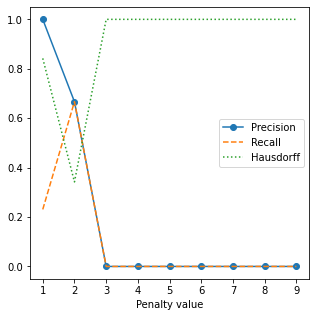

In [11]:
# Search for best parameters
P=[]
R=[]
H=[]
I=[]
v = np.arange(1,10)
for k in v:
    print(k)
    
    algo = rpt.Pelt(model="rbf").fit(rs2)
    result = algo.predict(pen=k)
    algo2 = rpt.Pelt(model="rbf").fit(isola2)
    resultisola = algo2.predict(pen=k)
    print(result)
    print(2*np.array(resultisola)-1)
    bkps1, bkps2 = result, 2*np.array(resultisola)-1
    if (len(result) or len(resultisola))==1:
        p,r=0,0
        P.append(p)
        R.append(r)
        H.append(h)
        I.append(i)
    else:
        p, r = precision_recall(bkps1, bkps2)
        h = hausdorff(bkps1, bkps2)
        i=randindex(bkps1, bkps2)
        P.append(p)
        R.append(r)
        H.append(h)
        I.append(i)
        

plt.plot(v,np.array(P),'-o',label="Precision")
plt.plot(v,np.array(R),'--',label="Recall")
plt.plot(v,np.array(H)/max(np.array(H)),':',label="Hausdorff")
#plt.plot(v,np.array(I),label="RandIndex")
plt.xlabel('Penalty value')
plt.legend()


fig = plt.gcf()
fig.set_size_inches(5, 5)
fig.savefig('CPAmetricsC.png', dpi=600)
